<a href="https://colab.research.google.com/github/sumanyurosha/emotion-detection/blob/master/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F

torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [0]:
import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

In [4]:
import syft as sy
hook = sy.TorchHook(torch)

# Create a couple of workers
bob = sy.VirtualWorker(hook, id="bob")  
alice = sy.VirtualWorker(hook, id="alice")

W0818 07:03:06.460136 140595261843328 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0818 07:03:06.479596 140595261843328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
import pickle

def covert_into_pickle(item, directory):
    pickle.dump(item, open(directory,'wb'))

def load_from_pickle(directory):
    return pickle.load(open(directory,'rb'))

In [7]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


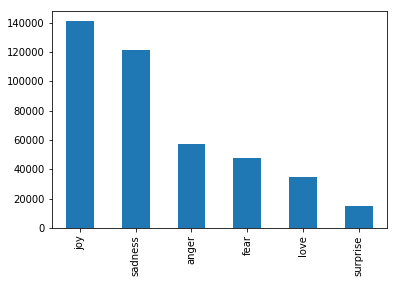

In [9]:
#load data
data = load_from_pickle(directory='/gdrive/My Drive/Resources/Dataset/emotion-detection/merged_training.pkl')
data.emotions.value_counts().plot.bar()

In [10]:
print(data.shape)
print(type(data))

(416809, 2)
<class 'pandas.core.frame.DataFrame'>


In [11]:
data.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [0]:
#copying data with number of tokens less than 70
data["token size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data["token size"] < 70].copy()

#sampling data
data = data.sample(n=50000, replace=True)

In [13]:
from nltk import word_tokenize

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
class ConstructDictionary():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2index = {}
        self.index2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        
        #creating tokens from sentences and adding them to dictionary
        for sentence in self.sentences:
            self.vocab.update(word_tokenize(sentence))
            
        #sorting the dictionary
        self.vocab = sorted(self.vocab)
        
        #adding padding token to 0 index
        self.word2index['<pad>'] = 0
           
        #creating a word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2index[word] = index + 1         #adding 1 becuase of padding element at 0 index
            
        #creating a index to word mapping
        for index, word in self.word2index.items():
            self.index2word[index] = word

In [19]:
inputs = ConstructDictionary(data["text"].values.tolist())
inputs.vocab[:10]

['a',
 'aaron',
 'abandoned',
 'abba',
 'abilities',
 'ability',
 'able',
 'abnormality',
 'abortion',
 'about']

In [20]:
len(inputs.vocab)

8167

In [21]:
input_tensors = [[inputs.word2index[word] for word in word_tokenize(sentence) ] for sentence in data['text'].values.tolist() ]
input_tensors[:2]

[[3485,
  2591,
  3624,
  7332,
  5573,
  7339,
  1,
  5838,
  4248,
  8011,
  2802,
  6321,
  7654,
  4103,
  703,
  7665,
  2947,
  7189,
  1075,
  3530,
  1780,
  5595,
  261,
  8161,
  3411],
 [3451,
  2589,
  513,
  2735,
  3310,
  2534,
  3400,
  3422,
  3310,
  7981,
  4675,
  2589,
  3400,
  2249,
  3310,
  3911,
  4675,
  2589,
  261,
  2735,
  7222,
  6664,
  7967,
  4835,
  3862,
  2763,
  4988,
  7967,
  3310,
  2559,
  3728,
  261,
  206,
  7222,
  4406,
  443,
  3747,
  4835,
  871,
  7665,
  3302,
  261,
  4113,
  3235,
  2811,
  6191,
  5156,
  390,
  7921]]

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [23]:
max_length_input = max_length(input_tensors)
print(max_length_input)

69


In [0]:
def pad_sequences(x, max_len=max_length_input):
    padded = np.zeros((max_len), dtype=np.int64)
    padded[:len(x)] = x
    return padded

In [25]:
input_tensors = [pad_sequences(x, max_length_input) for x in input_tensors]
input_tensors = 
input_tensors[:2]

[array([3485, 2591, 3624, 7332, 5573, 7339,    1, 5838, 4248, 8011, 2802,
        6321, 7654, 4103,  703, 7665, 2947, 7189, 1075, 3530, 1780, 5595,
         261, 8161, 3411,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]),
 array([3451, 2589,  513, 2735, 3310, 2534, 3400, 3422, 3310, 7981, 4675,
        2589, 3400, 2249, 3310, 3911, 4675, 2589,  261, 2735, 7222, 6664,
        7967, 4835, 3862, 2763, 4988, 7967, 3310, 2559, 3728,  261,  206,
        7222, 4406,  443, 3747, 4835,  871, 7665, 3302,  261, 4113, 3235,
        2811, 6191, 5156,  390, 7921,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])]

In [0]:
#now we are using transforming our target values using one-hot encoding

emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)

mlb = preprocessing.MultiLabelBinarizer()

data_labels = [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [27]:
target_tensor[:2]

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0]])

In [28]:
data[0:2]

,text,emotions,token size
131152,im feeling inspired to pull together a relaxed...,joy,25
28212,i feel badly for his family how humiliated his...,sadness,49


In [0]:
def get_emotion(x):
    return np.argmax(x)

In [30]:
get_emotion(target_tensor[0])

2

In [0]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [35]:
emotion_dict[get_emotion(target_tensor[0])]

'joy'

In [52]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensors, target_tensor, test_size=0.2)


# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

In [0]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2index)
target_size = num_emotions

In [0]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [0]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

syft.frameworks.torch.tensors.interpreters.native.Tensor

In [0]:
train_dataset = sy.BaseDataset(input_tensor_train, target_tensor_train).federate((alice,bob))
val_dataset = sy.BaseDataset(input_tensor_val, target_tensor_val).federate((alice,bob))
test_dataset = sy.BaseDataset(input_tensor_test, target_tensor_test).federate((alice,bob))





federated_train_loader = sy.FederatedDataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
federated_val_loader = sy.FederatedDataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
federated_test_loader = sy.FederatedDataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [70]:
input, labels = next(iter(train_dataset))
print(input[0].get(), labels[0].get())

tensor([3451, 2053, 7085, 6156, 3747, 2735, 6720, 4878,  261, 3451, 2053, 7085,
        2589, 3591,   10,  629, 5207, 8011, 2968,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], device='cpu') tensor([0, 0, 0, 0, 1, 0], device='cpu')


In [0]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden

In [0]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# obtain one sample from the data iterator
it = iter(train_dataset)
x, y = next(it)

# sort the batch first to be able to use with pac_pack sequence
#xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", x.size())

output, _ = model(x.to(device), device)
print(output.size())